In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline
np.random.seed(1)

/Users/huiw/.virtualenvs/py3_cv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
#load mnist data
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

y = 3
(28, 28)


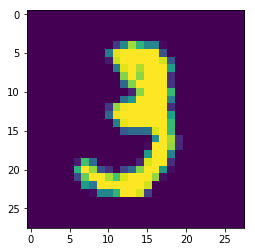

In [3]:
# Example of a picture
index = 10
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[index])))
print (X_train_orig[index].shape)

In [4]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [5]:
# reshape dataset from (60000, 28, 28) to (60000, 28, 28, 1)
img_rows, img_cols = 28,28
if K.image_data_format() == 'channels_first':
    X_train_orig = X_train_orig.reshape(X_train_orig.shape[0], 1, img_rows, img_cols)
    X_test_orig = X_test_orig.reshape(X_test_orig.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_orig = X_train_orig.reshape(X_train_orig.shape[0], img_rows, img_cols, 1)
    X_test_orig = X_test_orig.reshape(X_test_orig.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

    # Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 10).T
Y_test = convert_to_one_hot(Y_test_orig, 10).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


In [48]:
def MNIST_model(input_shape, classes = 10):
    
    X_input = Input(input_shape)
  
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (5, 5), name = 'conv1',padding = 'same')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    # MAXPOOL
    X = MaxPooling2D((2, 2),strides = (2, 2), name = 'max_pool1')(X)
    
    # branch1
    # CONV 1X1
    b1_X = Conv2D(64, (1, 1), name = 'conv2',padding = 'valid')(X)
    b1_X = BatchNormalization(axis = 3, name = 'bn2')(b1_X)
    b1_X = Activation('relu')(b1_X)
    b1_X = MaxPooling2D((3, 3), name='max_pool2')(b1_X)

    # branch2
    # CONV 1x1 -> CONV 3x3
    b2_X = Conv2D(64, (1, 1), name = 'conv3',padding = 'same')(X)
    b2_X = BatchNormalization(axis = 3, name = 'bn3')(b2_X)
    b2_X = Activation('relu')(b2_X)
    b2_X = Conv2D(64, (3, 3), name = 'conv4',padding = 'same')(b2_X)
    b2_X = BatchNormalization(axis = 3, name = 'bn4')(b2_X)
    b2_X = Activation('relu')(b2_X)
    b2_X = MaxPooling2D((3, 3), name='max_pool3')(b2_X)
    
    # branch3
    # CONV 1x1 -> CONV 5x5
    b3_X = Conv2D(64, (1, 1), name = 'conv5',padding = 'same')(X)
    b3_X = BatchNormalization(axis = 3, name = 'bn5')(b3_X)
    b3_X = Activation('relu')(b3_X)
    b3_X = Conv2D(64, (5, 5), name = 'conv6',padding = 'same')(b3_X)
    b3_X = BatchNormalization(axis = 3, name = 'bn6')(b3_X)
    b3_X = Activation('relu')(b3_X)
    b3_X = MaxPooling2D((3, 3), name='max_pool4')(b3_X)
    
    # branch4
    # MAXPOOL 3x3 -> CONV 1x1
    b4_X = MaxPooling2D((3, 3), name='max_pool5')(X)
    b4_X = Conv2D(64, (1, 1), name = 'conv7',padding = 'same')(b4_X)
    b4_X = BatchNormalization(axis = 3, name = 'bn7')(b4_X)
    b4_X = Activation('relu')(b4_X)
    
    # CONCAT
    concat = keras.layers.concatenate([b1_X, b2_X, b3_X, b4_X],axis=3)
    X = Activation('relu')(concat)
    
    #X = Flatten()(X)
    X = Dense(128, activation='relu', name='fc1')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc2')(X)
    # Create model. 
    model = Model(inputs = X_input, outputs = X, name='MNIST')

    return model

In [49]:
MNISTmodel = MNIST_model((28,28,1),classes = 10)

In [36]:
MNISTmodel.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [41]:
MNISTmodel.fit(X_train, Y_train, epochs = 10, batch_size = 200)

Epoch 1/10
60000/60000 [==============================] - 492s 8ms/step - loss: 0.0260 - acc: 0.9919
Epoch 2/10
60000/60000 [==============================] - 470s 8ms/step - loss: 0.0194 - acc: 0.9940
Epoch 3/10
60000/60000 [==============================] - 499s 8ms/step - loss: 0.0143 - acc: 0.9956
Epoch 4/10
60000/60000 [==============================] - 485s 8ms/step - loss: 0.0111 - acc: 0.9966
Epoch 5/10
60000/60000 [==============================] - 527s 9ms/step - loss: 0.0084 - acc: 0.9975
Epoch 6/10
60000/60000 [==============================] - 471s 8ms/step - loss: 0.0078 - acc: 0.9976
Epoch 7/10
60000/60000 [==============================] - 475s 8ms/step - loss: 0.0069 - acc: 0.9978
Epoch 8/10
60000/60000 [==============================] - 543s 9ms/step - loss: 0.0106 - acc: 0.9966
Epoch 9/10
60000/60000 [==============================] - 554s 9ms/step - loss: 0.0057 - acc: 0.9983
Epoch 10/10
60000/60000 [==============================] - 498s 8ms/step - loss: 0.0045 - a

In [42]:
MNISTmodel.save('MNISTmodel.h5')

In [43]:
preds = MNISTmodel.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10000/10000 [==============================] - 39s 4ms/step
Loss = 0.03449124326272904
Test Accuracy = 0.9902


In [45]:
MNISTmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 28, 32)   832         input_13[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 28, 28, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 28, 28, 32)   0           bn1[0][0]                        
__________________________________________________________________________________________________
max_pool1 

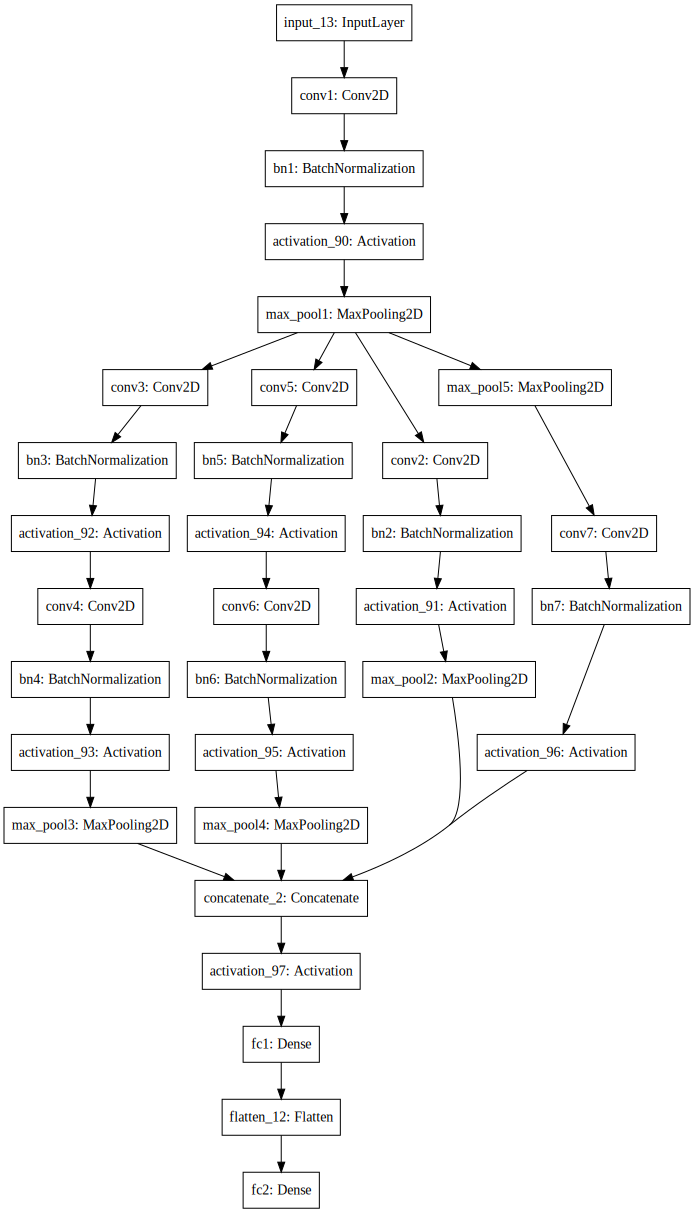

In [47]:
plot_model(MNISTmodel, to_file='model.png')
SVG(model_to_dot(MNISTmodel).create(prog='dot', format='svg'))

In [53]:
tf.keras.models.save_model(MNISTmodel, 'MNISTmodel.h5')